# Feature Selection in Data Science: A Hybrid Approach

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

## Feature Selector Implementation

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    A hybrid feature selection method combining tree-based feature importance and clustering.
    """
    
    def __init__(self, task_type='classification', n_clusters=None, importance_threshold=0.01):
        """
        Parameters:
        - task_type: 'classification' or 'regression'
        - n_clusters: If provided (an integer), cluster the features into this many groups 
                      and select one feature per cluster. If None, select all features above
                      the importance threshold.
        - importance_threshold: Only features with importance greater than this threshold are considered.
        """
        self.task_type = task_type
        self.n_clusters = n_clusters
        self.importance_threshold = importance_threshold
        
        # Initialize the appropriate RandomForest model
        if self.task_type == 'classification':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        self.selected_features_ = None
        self.feature_importance_ = None
    
    def fit(self, X, y):
        self.model.fit(X, y)
        importance = self.model.feature_importances_
        self.feature_importance_ = pd.Series(importance, index=X.columns)
    
    # Select features above the importance threshold
        important_features = self.feature_importance_[self.feature_importance_ > self.importance_threshold]
    
    # If n_clusters is not specified or if there are fewer important features than n_clusters,
    # then select all important features.
        if self.n_clusters is None or len(important_features) <= self.n_clusters:
            self.selected_features_ = list(important_features.index)
            return self
    
    # Get important features subset
        X_important = X[important_features.index]
    
    # Compute correlation matrix
        corr_matrix = X_important.corr().abs()
        correlation_threshold=0.8
    # Create a custom distance matrix that combines:
    # 1. Correlation (similarity)
    # 2. Feature importance difference (to prioritize keeping high-importance features)
        distance_matrix = np.zeros((len(important_features), len(important_features)))
    
        for i, feat1 in enumerate(important_features.index):
            for j, feat2 in enumerate(important_features.index):
            # Get correlation
                correlation = corr_matrix.loc[feat1, feat2]
            
                if i == j:  # Zero distance to self
                    distance_matrix[i, j] = 0
                elif correlation < correlation_threshold:
                # Not correlated enough - set to "infinity" to prevent clustering
                    distance_matrix[i, j] = 9999.0  # Very large distance
                else:
                # Original distance calculation for correlated features
                    correlation_distance = 1 - correlation
                    importance_diff = abs(important_features[feat1] - important_features[feat2])
                    alpha = 0.7  # Weight for correlation component
                    distance_matrix[i, j] = alpha * correlation_distance + (1-alpha) * importance_diff
    
    # Use hierarchical clustering instead of KMeans for more flexibility with custom distance
        from scipy.cluster.hierarchy import linkage, fcluster
        Z = linkage(distance_matrix, method='ward')
        clusters = fcluster(Z, t=self.n_clusters, criterion='maxclust')
        
        # For each cluster, select the feature with the highest importance
        selected_features = []
        for cluster_id in range(1, self.n_clusters + 1):  # hierarchical clusters are 1-indexed
            cluster_features = important_features[clusters == cluster_id]
            if not cluster_features.empty:
                best_feature = cluster_features.idxmax()
                selected_features.append(best_feature)
        
        self.selected_features_ = selected_features
        self.feature_clusters_ = pd.Series(clusters, index=important_features.index)
        return self
    
    def transform(self, X):
        """
        Transform X to retain only the selected features.
        """
        if self.selected_features_ is None:
            raise ValueError("Call 'fit' before calling transform.")
        return X[self.selected_features_]
    
    def fit_transform(self, X, y):
        """
        Fit to the data, then transform it.
        """
        return self.fit(X, y).transform(X)


## Evaluation Functions

In [3]:
def evaluate_method(X, y, method, task_type='classification'):
    """Evaluate a feature selection method."""
    # Time the selection process
    start_time = time.time()
    
    # Handle PCA separately since it doesn't need y for fit
    if isinstance(method, PCA):
        X_selected = method.fit_transform(X)
    else:
        # For other methods, use fit_transform with both X and y
        X_selected = method.fit_transform(X, y)
    
    selection_time = time.time() - start_time
    
    # Create appropriate model and scorer based on task type
    if task_type == 'classification':
        model = RandomForestClassifier(random_state=42)
        scorer = make_scorer(accuracy_score)
    else:
        model = RandomForestRegressor(random_state=42)
        scorer = make_scorer(r2_score)
    
    # Calculate cross-validation scores
    scores = cross_val_score(model, X_selected, y, scoring=scorer, cv=5)
    
    return {
        'mean_score': scores.mean(),
        'std_score': scores.std(),
        'selection_time': selection_time,
        'n_features': X_selected.shape[1]
    }

def compare_methods(X, y, task_type='classification', importance_threshold=0.01, pca_variance=0.95):
    """Compare different feature selection methods with automatic feature number selection."""
    # Create base estimator based on task type
    if task_type == 'classification':
        base_estimator = RandomForestClassifier(random_state=42)
    else:
        base_estimator = RandomForestRegressor(random_state=42)
    
    # Initialize methods:
    # For our method, if n_clusters is None, it returns all features above threshold.
    custom_method = FeatureSelector(task_type=task_type, n_clusters=None, 
                                    importance_threshold=importance_threshold)
    
    # Use RFECV for RFE so it selects the optimal number of features automatically.
    from sklearn.feature_selection import RFECV
    rfe_method = RFECV(estimator=base_estimator, cv=5)
    
    # For PCA, use a variance threshold (e.g., 95%) so that PCA determines the number of components.
    pca_method = PCA(n_components=pca_variance)
    
    methods = {
        'Our Method': custom_method,
        'RFE': rfe_method,
        'PCA': pca_method
    }
    
    # Evaluate each method
    results = {}
    for name, method in methods.items():
        results[name] = evaluate_method(X, y, method, task_type)
    
    return results

def plot_comparison(results, title):
    """Create comparison plots."""
    metrics = ['mean_score', 'n_features', 'selection_time']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        data = [results[method][metric] for method in results.keys()]
        axes[i].bar(results.keys(), data)
        axes[i].set_title(f'{metric.replace("_", " ").title()}')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for j, v in enumerate(data):
            axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()

## Run Experiments


Wine Dataset Results:

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.9665   0.9721  0.7079
std_score           0.0207   0.0176  0.0418
selection_time      0.1336  10.3918  0.0023
n_features         11.0000  13.0000  1.0000


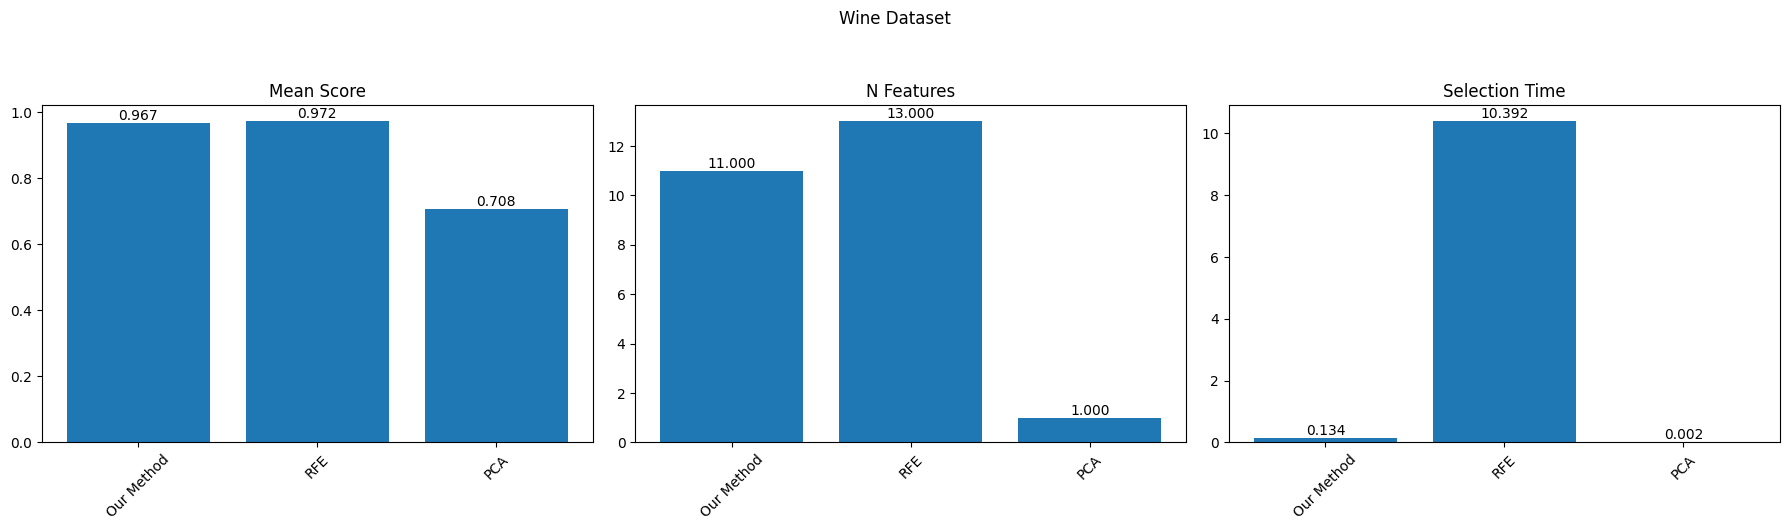


Cancer Dataset Results:

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.9596   0.9666  0.8489
std_score           0.0190   0.0195  0.0207
selection_time      0.4120  29.8066  0.0022
n_features          3.0000  16.0000  1.0000


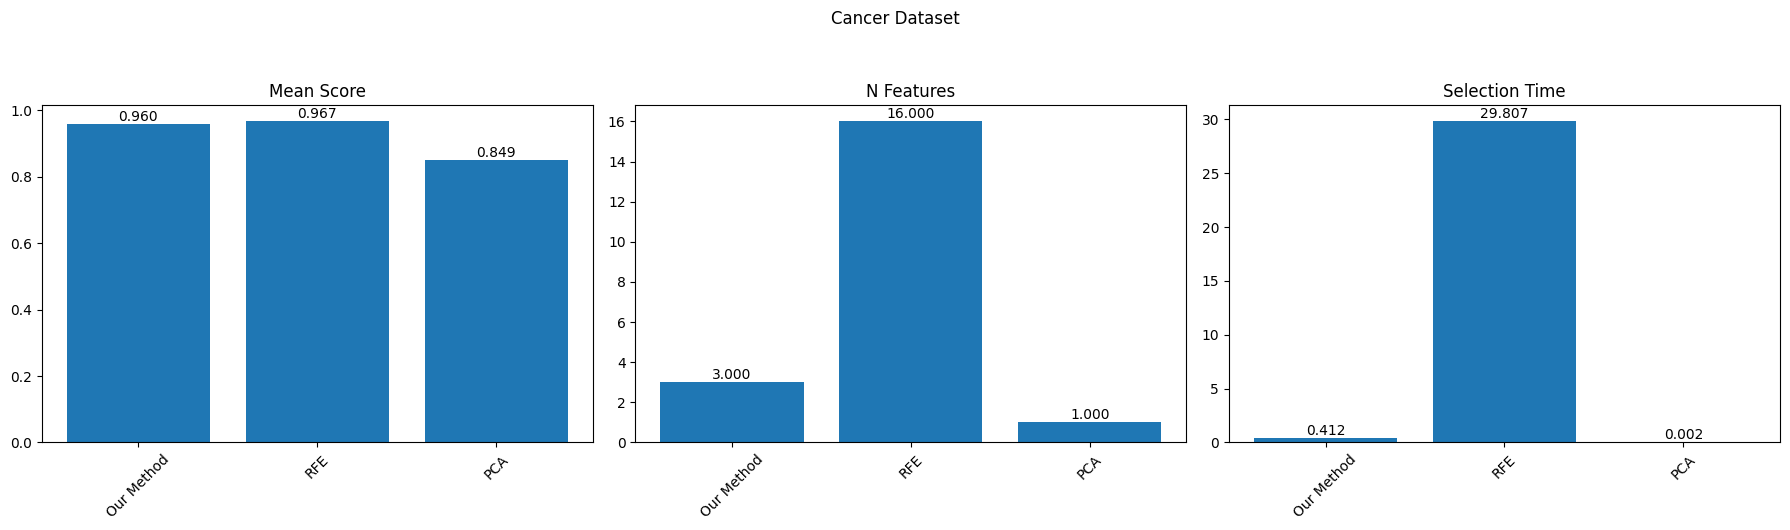


Diabetes Dataset Results:

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.4175   0.4184  0.4506
std_score           0.0557   0.0559  0.0810
selection_time      0.3488  10.2701  0.0021
n_features          9.0000  10.0000  8.0000


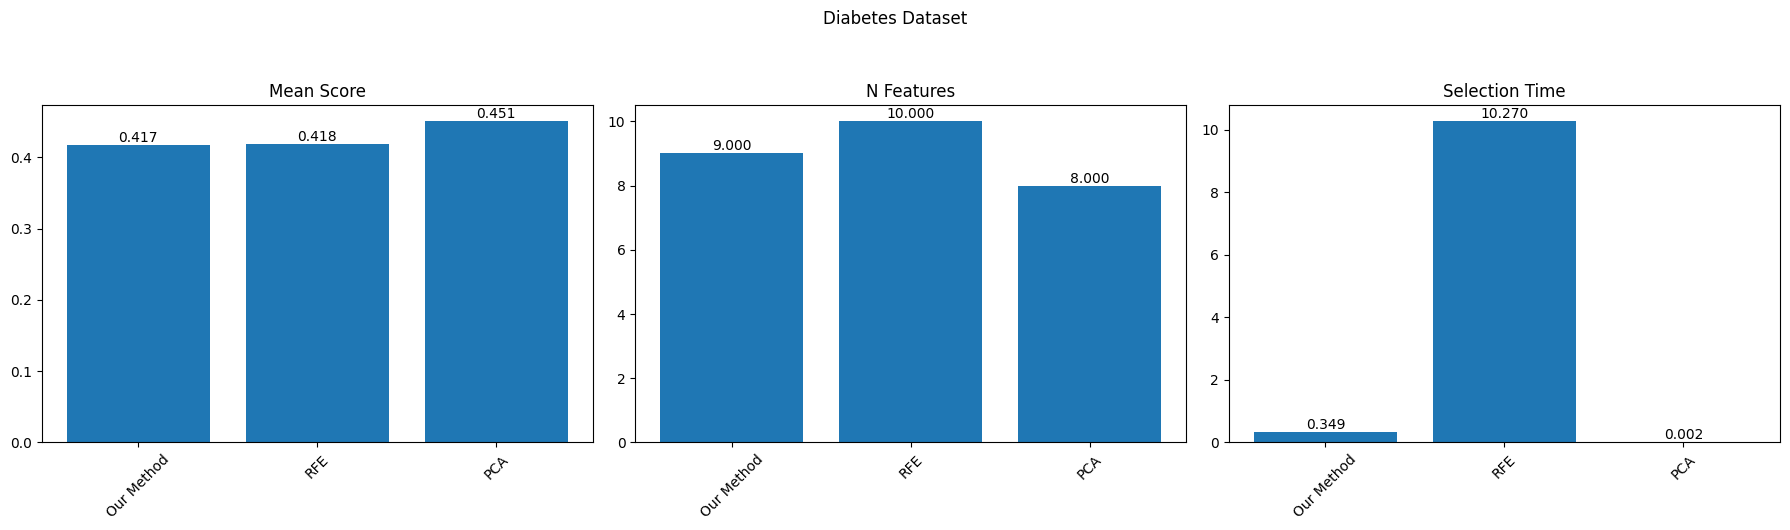

In [8]:
# Load datasets
from sklearn.datasets import load_wine, fetch_california_housing
from sklearn.datasets import load_breast_cancer, load_diabetes

# Prepare datasets
datasets = {
    'Wine': (load_wine(), 'classification'),
    'Cancer': (load_breast_cancer(), 'classification'),
    'Diabetes': (load_diabetes(), 'regression')
}

# Run experiments
for name, (data, task) in datasets.items():
    print(f"\n{name} Dataset Results:")
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    results = compare_methods(X, y, task)
    print("\nDetailed Results:")
    print(pd.DataFrame(results).round(4))
    
    # Plot comparisons
    plot_comparison(results, f'{name} Dataset')

## Analyze Feature Groups


=== Wine Dataset Analysis ===


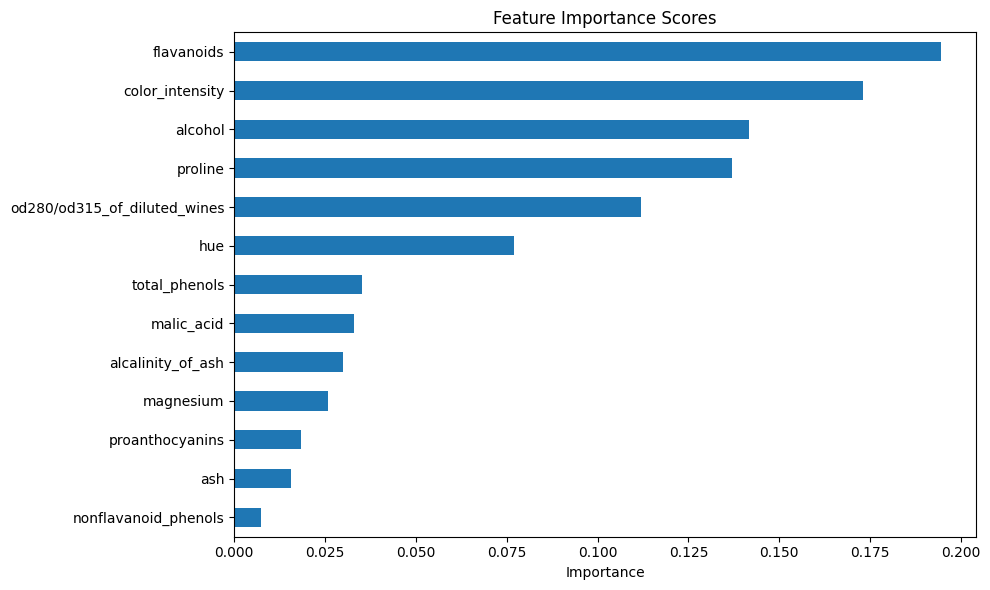


Selected Features:
alcohol: 0.1416
malic_acid: 0.0331
ash: 0.0155
alcalinity_of_ash: 0.0299
magnesium: 0.0259
total_phenols: 0.0351
flavanoids: 0.1945
proanthocyanins: 0.0184
color_intensity: 0.1730
hue: 0.0769
od280/od315_of_diluted_wines: 0.1118
proline: 0.1370

Feature Clusters and Selections:

Cluster 1 (Average correlation: 0.8646):
  ★ flavanoids: importance=0.1945, highest corr: 0.8646 with total_phenols
    total_phenols: importance=0.0351, highest corr: 0.8646 with flavanoids

Cluster 2 (Average correlation: 0.2914):
  ★ color_intensity: importance=0.1730, highest corr: 0.5218 with hue
    od280/od315_of_diluted_wines: importance=0.1118, highest corr: 0.5655 with hue
    hue: importance=0.0769, highest corr: 0.5655 with od280/od315_of_diluted_wines
    magnesium: importance=0.0259, highest corr: 0.2364 with proanthocyanins
    proanthocyanins: importance=0.0184, highest corr: 0.5191 with od280/od315_of_diluted_wines

Cluster 3 (Average correlation: 0.2986):
  ★ malic_acid: im

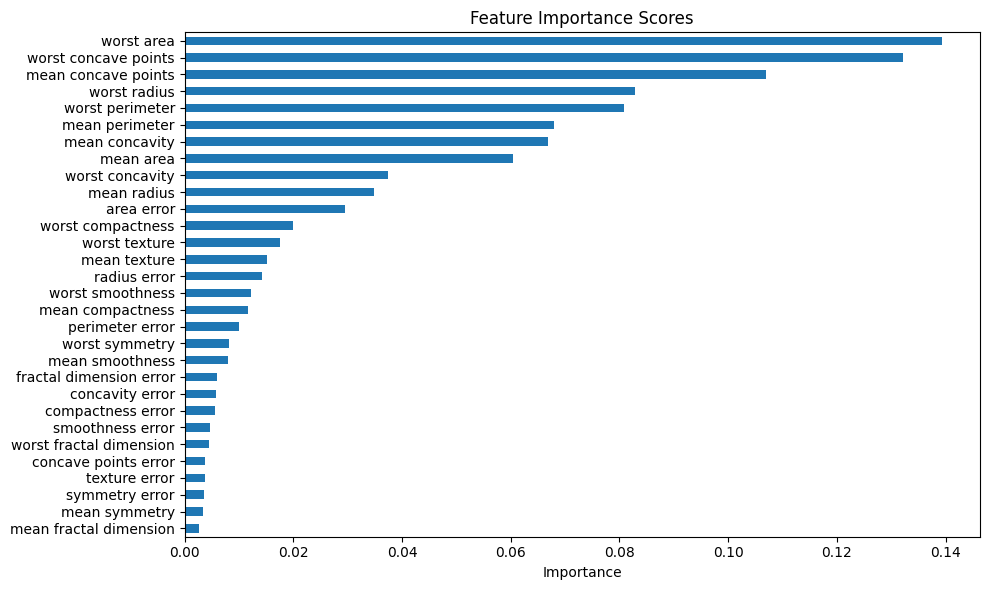


Selected Features:
mean radius: 0.0348
mean texture: 0.0152
mean perimeter: 0.0680
mean area: 0.0605
mean compactness: 0.0116
mean concavity: 0.0669
mean concave points: 0.1070
radius error: 0.0143
perimeter error: 0.0101
area error: 0.0296
worst radius: 0.0828
worst texture: 0.0175
worst perimeter: 0.0808
worst area: 0.1394
worst smoothness: 0.0122
worst compactness: 0.0199
worst concavity: 0.0373
worst concave points: 0.1322

Feature Clusters and Selections:

Cluster 1 (Average correlation: 0.9710):
  ★ worst area: importance=0.1394, highest corr: 0.9840 with worst radius
    worst radius: importance=0.0828, highest corr: 0.9937 with worst perimeter
    worst perimeter: importance=0.0808, highest corr: 0.9937 with worst radius
    mean perimeter: importance=0.0680, highest corr: 0.9979 with mean radius
    mean area: importance=0.0605, highest corr: 0.9874 with mean radius
    mean radius: importance=0.0348, highest corr: 0.9979 with mean perimeter

Cluster 2 (Single feature):
  ★ m

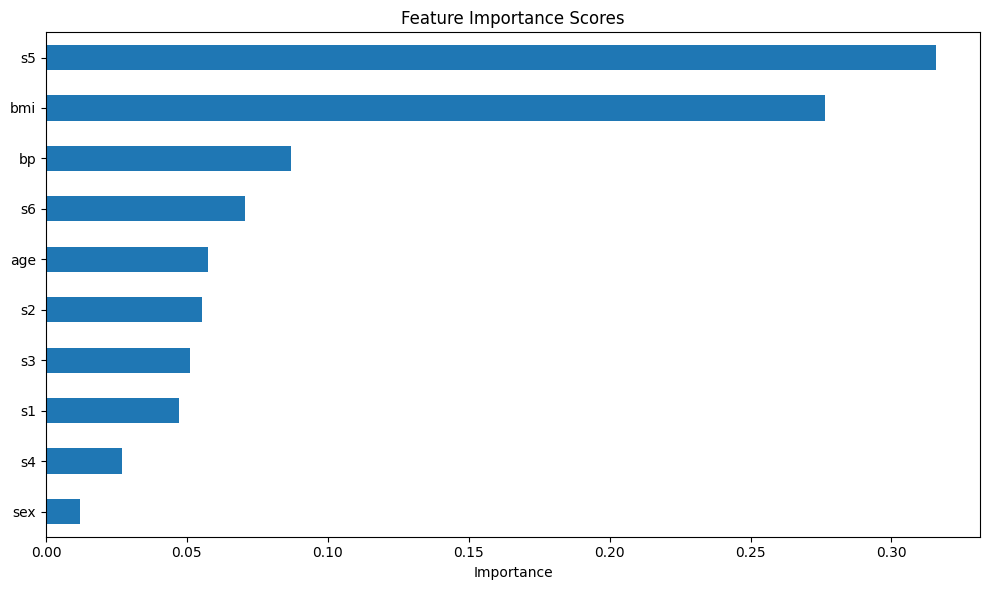


Selected Features:
age: 0.0575
sex: 0.0119
bmi: 0.2762
bp: 0.0871
s1: 0.0473
s2: 0.0554
s3: 0.0512
s4: 0.0271
s5: 0.3156
s6: 0.0708

Feature Clusters and Selections:

Cluster 1 (Average correlation: 0.8967):
  ★ s2: importance=0.0554, highest corr: 0.8967 with s1
    s1: importance=0.0473, highest corr: 0.8967 with s2

Cluster 2 (Average correlation: 0.4851):
  ★ s5: importance=0.3156, highest corr: 0.6179 with s4
    s6: importance=0.0708, highest corr: 0.4647 with s5
    s3: importance=0.0512, highest corr: 0.7385 with s4
    s4: importance=0.0271, highest corr: 0.7385 with s3

Cluster 3 (Average correlation: 0.2415):
  ★ bmi: importance=0.2762, highest corr: 0.3954 with bp
    bp: importance=0.0871, highest corr: 0.3954 with bmi
    sex: importance=0.0119, highest corr: 0.2410 with bp

Cluster 4 (Single feature):
  ★ age: importance=0.0575, single feature


In [6]:
def analyze_selected_features(X, y, task_type):
    """Analyze which features were selected and why."""
    selector = FeatureSelector(task_type=task_type)
    selector.fit(X, y)
    
    # Create feature importance visualization
    plt.figure(figsize=(10, 6))
    selector.feature_importance_.sort_values().plot(kind='barh')
    plt.title('Feature Importance Scores')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Print selected features and their importance
    print("\nSelected Features:")
    for feature in selector.selected_features_:
        print(f"{feature}: {selector.feature_importance_[feature]:.4f}")

# Analyze each dataset
def display_cluster_selections(selector, X):
    """Display which features were grouped together, which was selected, and their correlations."""
    if not hasattr(selector, 'feature_clusters_'):
        print("Clustering was not performed in this selector.")
        return
    
    # Calculate correlation matrix for all features
    corr_matrix = X.corr().abs()
    
    # Get all clusters (hierarchical clustering is 1-indexed)
    clusters = sorted(selector.feature_clusters_.unique())
    
    print("\nFeature Clusters and Selections:")
    for cluster_id in clusters:
        # Get features in this cluster
        cluster_features = selector.feature_clusters_[selector.feature_clusters_ == cluster_id].index
        
        # Get the selected feature from this cluster
        selected = [f for f in cluster_features if f in selector.selected_features_]
        selected_str = selected[0] if selected else "None"
        
        # Get importances for features in this cluster
        importances = {f: selector.feature_importance_[f] for f in cluster_features}
        
        # Calculate average correlation within this cluster
        if len(cluster_features) > 1:
            cluster_corr = corr_matrix.loc[cluster_features, cluster_features]
            avg_corr = (cluster_corr.sum().sum() - len(cluster_features)) / (len(cluster_features) * (len(cluster_features) - 1))
            print(f"\nCluster {cluster_id} (Average correlation: {avg_corr:.4f}):")
        else:
            print(f"\nCluster {cluster_id} (Single feature):")
        
        # Print feature details with highest correlation to another feature in the cluster
        for feature, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True):
            marker = "★" if feature == selected_str else " "
            
            # Find highest correlation with another feature in this cluster
            if len(cluster_features) > 1:
                # Get correlations with other features in this cluster
                feature_corrs = corr_matrix.loc[feature, cluster_features]
                # Remove self-correlation (which is always 1.0)
                feature_corrs = feature_corrs[feature_corrs.index != feature]
                # Get highest correlation
                if not feature_corrs.empty:
                    highest_corr_feat = feature_corrs.idxmax()
                    highest_corr_val = feature_corrs.max()
                    corr_info = f"highest corr: {highest_corr_val:.4f} with {highest_corr_feat}"
                else:
                    corr_info = "no correlations"
            else:
                corr_info = "single feature"
                
            print(f"  {marker} {feature}: importance={importance:.4f}, {corr_info}")
for name, (data, task) in datasets.items():
    print(f"\n=== {name} Dataset Analysis ===")
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    
    # Create and fit the selector
    selector = FeatureSelector(task_type=task, n_clusters=min(5, X.shape[1]//2))
    selector.fit(X, y)
    
    # Analyze selected features
    analyze_selected_features(X, y, task)
    
    # Display cluster selections
    display_cluster_selections(selector,X)